# MACHINE ANOMALY DETECTION USING PCA AND AUTOENCODER

In [1]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from numpy.random import seed
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


C:\Users\pavit\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
dataset_train=pd.read_csv('PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','Machine_Cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,Machine_Cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
dataset_test=pd.read_csv('PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','Machine','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Test dataset: ',dataset_test.shape)
dataset_test.head()

Shape of Test dataset:  (13096, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


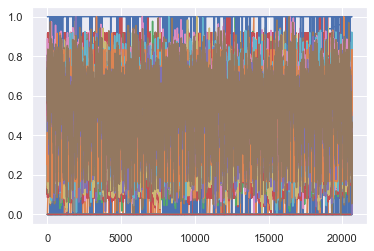

In [4]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)
plt.plot(X_train)
plt.show()


# PCA 

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [6]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [7]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [8]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [9]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [10]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [11]:


data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)
data_train

array([[-0.50570357,  0.4864006 ],
       [-0.43324837,  0.49228145],
       [-0.50893454,  0.49449174],
       ...,
       [ 1.16563538, -0.43853277],
       [ 1.14955898, -0.43769693],
       [ 1.15838332, -0.45158984]])

In [12]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)
cov_matrix

array([[1.97428096e-01, 8.61055181e-18],
       [8.61055181e-18, 8.72450354e-02]])

In [13]:
mean_distr = data_train.mean(axis=0)
mean_distr

array([ 2.30751603e-17, -3.30629163e-17])

In [14]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)
dist_test

[1.9573068533086084,
 2.1245680990264804,
 1.9336195481989695,
 1.9827269744760088,
 2.0777092244424797,
 2.070850677250497,
 2.018256334531353,
 1.9615890289231834,
 1.977961379139611,
 2.073780894202731,
 2.1238350033809676,
 2.091651071733248,
 2.0347083435308773,
 2.06013207267525,
 1.9625214178788069,
 1.895967718758438,
 2.0138373551101654,
 1.9248008989773067,
 2.07277197954026,
 1.933682844455478,
 1.9543700833362694,
 1.8746268053459498,
 2.080045243145866,
 1.8625471479184776,
 1.9411212090371674,
 1.907332212761541,
 1.9216173307395175,
 1.9040472234250274,
 1.995313395591672,
 1.9268430856153138,
 1.9385535313746067,
 1.787409564883159,
 1.7787143080453884,
 1.7688140171171793,
 1.8339946992510536,
 1.7575595874048344,
 1.7810312976746077,
 1.7475177283110268,
 1.7653028954164274,
 1.7418080618210439,
 1.7632345379170804,
 1.7626761291575812,
 1.7198120474360468,
 1.7820758769738752,
 1.751301522721801,
 1.760885659514535,
 1.7452591210883264,
 1.802235419473836,
 1.7402134

(0.0, 15)

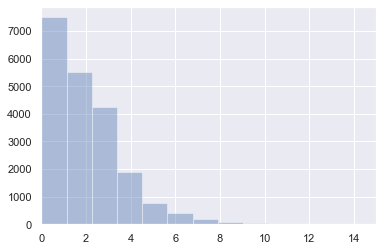

In [15]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

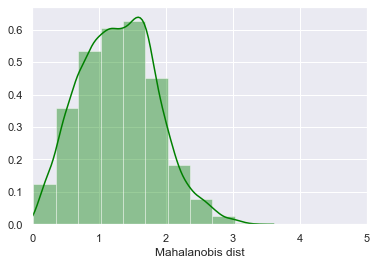

In [16]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [17]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
0,1.957307,3.880702,False
1,2.124568,3.880702,False
2,1.933620,3.880702,False
3,1.982727,3.880702,False
4,2.077709,3.880702,False


In [18]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

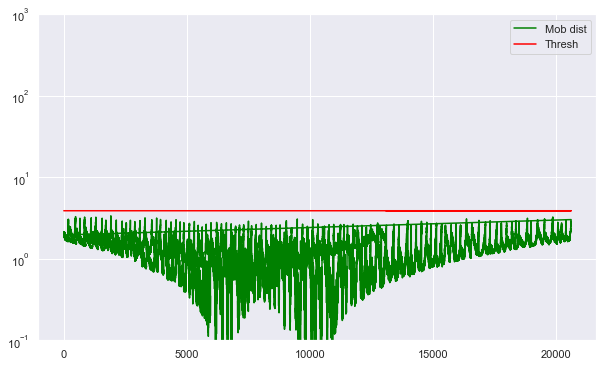

In [19]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

# AUTOENCODER

In [5]:
act_func = 'elu'
# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )
model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 26)                286       
Total params: 608
Trainable params: 608
Non-trainable params: 0
_________________________________________________________________


In [6]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/100
1960/1960 [==============================] - 7s 4ms/step - loss: 0.0181 - accuracy: 0.9569 - val_loss: 0.0134 - val_accuracy: 0.7936
Epoch 2/100
1960/1960 [==============================] - 5s 3ms/step - loss: 0.0084 - accuracy: 0.9763 - val_loss: 0.0085 - val_accuracy: 0.7936
Epoch 3/100
1960/1960 [==============================] - 5s 3ms/step - loss: 0.0075 - accuracy: 0.9710 - val_loss: 0.0075 - val_accuracy: 0.6017
Epoch 4/100
1960/1960 [==============================] - 7s 3ms/step - loss: 0.0074 - accuracy: 0.9686 - val_loss: 0.0070 - val_accuracy: 0.7200
Epoch 5/100
1960/1960 [==============================] - 7s 3ms/step - loss: 0.0074 - accuracy: 0.9719 - val_loss: 0.0069 - val_accuracy: 0.6143
Epoch 6/100
1960/1960 [==============================] - 7s 4ms/step - loss: 0.0074 - accuracy: 0.9729 - val_loss: 0.0070 - val_accuracy: 0.6870
Epoch 7/100
1960/1960 [==============================] - 7s 4ms/step - loss: 0.0074 - accuracy: 0.9728 - val_loss: 0.0070 - val_ac

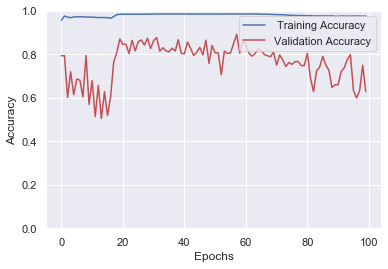

In [11]:
plt.plot(history.history['accuracy'],
         'b',
         label=' Training Accuracy')
plt.plot(history.history['val_accuracy'],
         'r',
         label='Validation Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.show()

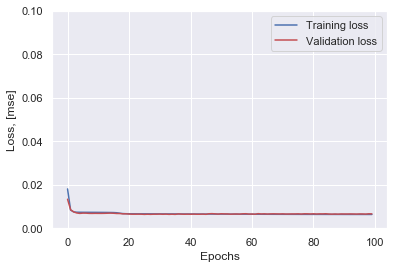

In [8]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

(0.0, 0.5)

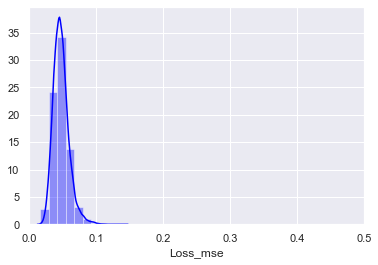

In [16]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mse'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [9]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.125
scored['Anomaly'] = scored['Loss_mse'] > scored['Threshold']
scored.head()

,Loss_mse,Threshold,Anomaly
0,0.050477,0.125,False
1,0.055452,0.125,False
2,0.037016,0.125,False
3,0.043015,0.125,False
4,0.034332,0.125,False


In [10]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mse'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.125
scored_train['Anomaly'] = scored_train['Loss_mse'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

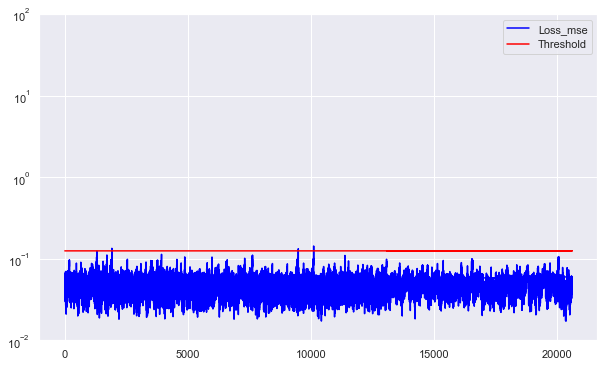

In [11]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])